# Sky Camera

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

In [3]:
import scipy.interpolate

In [218]:
import astropy.table
import astropy.constants
import astropy.io.ascii
import astropy.units as u

In [6]:
import skycalc_cli.skycalc

In [216]:
import requests

In [217]:
import speclite.filters

## Focal Plane

In [1031]:
fiberpos = astropy.table.Table.read(
    os.path.join(os.environ['DESIMODEL'], 'data', 'focalplane', 'fiberpos-all.fits'))

In [1032]:
np.unique(fiberpos['DEVICE_TYPE'])

ETC
FIF
GIF
NON
OPT
POS


In [1034]:
skyfibers = fiberpos[fiberpos['DEVICE_TYPE'] == 'ETC']

In [1041]:
r_skyfibers = np.unique(np.round(np.sqrt(skyfibers['X'] ** 2 + skyfibers['Y'] ** 2), 6))

In [1042]:
r_skyfibers

array([ 408.255151,  410.727925])

In [9]:
gfas = astropy.table.Table.read(
    os.path.join(os.environ['DESIMODEL'], 'data', 'focalplane', 'gfa.ecsv'),
    format='ascii.ecsv')

In [10]:
gfas[:8]

PETAL,CORNER,X,Y,Z,Q,S,RADIUS_DEG
,,mm,mm,mm,degrees,mm,degrees
int64,int64,float64,float64,float64,float64,float64,float64
0,0,116.279135125,-372.885546515,-17.053,287.31935812,391.101493471,1.54426530072
0,1,121.005023896,-387.429771497,-18.487,287.345026987,406.461953698,1.59998163278
0,2,91.7842871639,-396.910065893,-18.631,283.020607591,407.966640792,1.60541232205
0,3,87.0587074103,-382.364889854,-17.198,282.8267193,392.663773778,1.54995479059
1,0,313.248421442,-233.323583311,-17.053,323.31935812,391.101493471,1.54426530072
1,1,325.620626721,-242.312300768,-18.487,323.345026987,406.461953698,1.59998163278
1,2,307.55293135,-267.157538158,-18.631,319.020607591,407.966640792,1.60541232205
1,3,295.180417054,-258.167869645,-17.198,318.8267193,392.663773778,1.54995479059


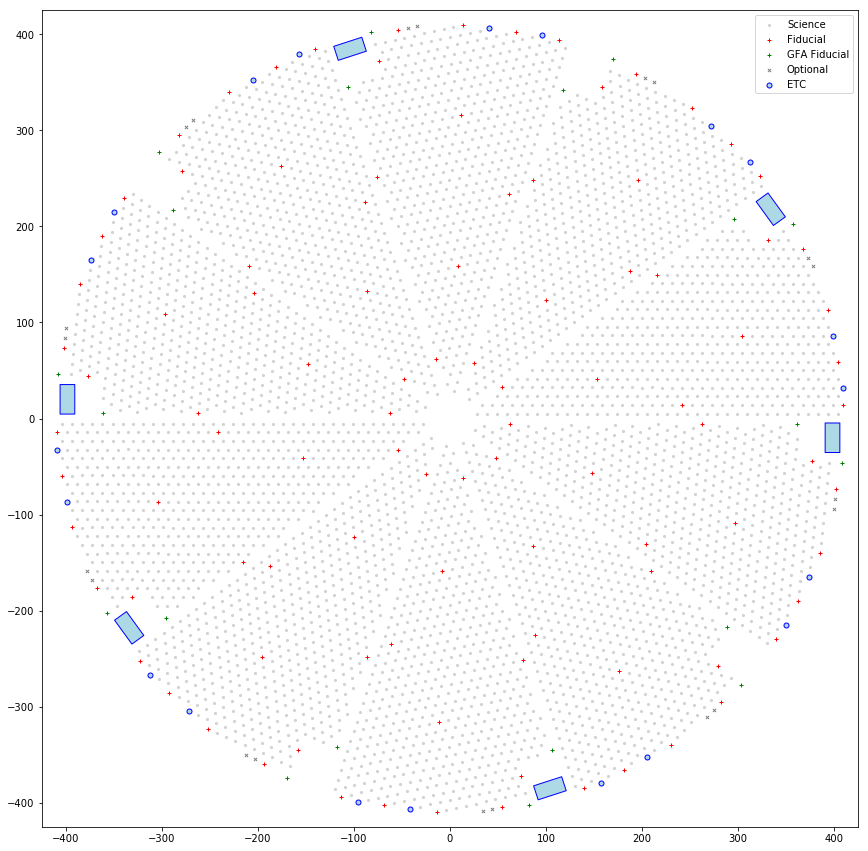

In [11]:
def plot_focalplane(save=None):
    fig = plt.figure(figsize=(12, 12))
    x = fiberpos['X']
    y = fiberpos['Y']
    pos = fiberpos['DEVICE_TYPE'] == 'POS'
    fif = fiberpos['DEVICE_TYPE'] == 'FIF'
    opt = fiberpos['DEVICE_TYPE'] == 'OPT'
    gif = fiberpos['DEVICE_TYPE'] == 'GIF'
    sky = fiberpos['DEVICE_TYPE'] == 'ETC'
    plt.scatter(x[pos], y[pos], s=10, lw=0, c='lightgray', label='Science')
    plt.scatter(x[fif], y[fif], s=10, lw=1, marker='+', c='red', label='Fiducial')
    plt.scatter(x[gif], y[gif], s=10, lw=1, marker='+', c='green', label='GFA Fiducial')
    plt.scatter(x[opt], y[opt], s=10, lw=1, marker='x', c='gray', label='Optional')
    plt.scatter(x[sky], y[sky], s=25, lw=1, edgecolors='blue', facecolors='lightblue', label='ETC')
    
    # Plot GFAs
    x = gfas['X']
    y = gfas['Y']
    xy = np.empty((4, 2))
    polygons = []
    gfa_type = 'GWGGWGWGGW'
    for petal in range(10):
        if gfa_type[petal] == 'W':
            # Skip wavefront sensors.
            continue
        sel = gfas['PETAL'] == petal
        xy[:, 0] = x[sel]
        xy[:, 1] = y[sel]
        polygons.append(matplotlib.patches.Polygon(xy, closed=True))
    patches = matplotlib.collections.PatchCollection(polygons, edgecolor='blue', facecolor='lightblue')
    plt.gca().add_collection(patches)
    
    plt.legend()
    plt.gca().set_aspect(1)
    xylim = 425
    plt.xlim(-xylim, +xylim)
    plt.ylim(-xylim, +xylim)
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_focalplane(save='etc_focalplane.png')

## Optics

What is $A\Omega$ for a sky fiber?  Can either calculate at the fiber (as in DESI-2499 cells G25:28) or at the primary mirror (as in specsim).

In [17]:
def AOmega(units = u.cm ** 2 * u.steradian):
    Dfiber = 107 * u.micron
    Afiber = np.pi * (Dfiber / 2) ** 2
    # calculate at sky fiber
    f_number_fiber = 3.8
    Omega1 = (np.pi/4) / f_number_fiber ** 2 * u.steradian
    AO1 = (Afiber * Omega1).to(units)
    print('fiber: AOmega = {:.3g}'.format(AO1))
    # calculate at primary mirror
    Dprim = 4.0 * u.m
    Aprim = (np.pi/4) * Dprim ** 2
    platescale_mer = 77.0 * u.micron / u.arcsec
    platescale_sag = 70.5 * u.micron / u.arcsec
    Omega2 = (np.pi/4) * Dfiber ** 2 / (platescale_mer * platescale_sag)
    print('fiber sky area = {:.3f}'.format(Omega2))
    AO2 = (Aprim * Omega2).to(units)
    print('prim: Aomega = {:.3g}'.format(AO2))
    
AOmega()

fiber: AOmega = 4.89e-06 cm2 sr
fiber sky area = 1.656 arcsec2
prim: Aomega = 4.89e-06 cm2 sr


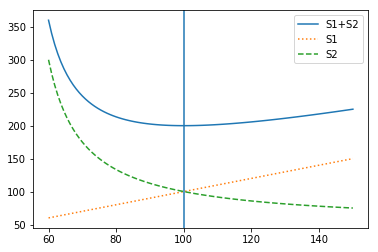

In [81]:
def plot_focus(flen=50):
    S1 = np.linspace(flen+10, 3 * flen, 100)
    S2 = flen * S1 / (S1 - flen)
    plt.plot(S1, S1 + S2, label='S1+S2')
    plt.plot(S1, S1, ':', label='S1')
    plt.plot(S1, S2, '--', label='S2')
    plt.axvline(2 * flen)
    plt.legend()
    
plot_focus()

# Fiber Packing

Try packing fibers with individual SMA905 connectors (OD 7.9mm) on a hexagonal grid:

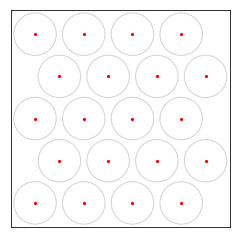

In [14]:
def hexpack(nx=4, ny= 5, r=0.5):
    dy = np.sqrt(3) * r
    dx = 2 * r
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy
    xx, yy = np.meshgrid(x, y)
    xx[1::2] += r
    plt.scatter(xx, yy, s=1800, facecolors='none', edgecolors='lightgray')
    plt.scatter(xx, yy, s=10, facecolors='red', lw=0)
    plt.gca().set_aspect(1)
    plt.xlim(x[0] - r, x[-1] + 2 * r)
    plt.ylim(y[0] - r, y[-1] + r)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
hexpack()
plt.savefig('skycam-image.png')

## Nominal Sky Conditions

Use the ESO SkyCalc [command-line interface](https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html) (see [Noll 2012](https://arxiv.org/abs/1205.2003) for details of the sky model) to predict nominal DARK, GRAY, BRIGHT sky surface brightness:
 - DARK: best guess at dark possible conditions, at zenith (X=1), moon below horizon, and away from the ecliptic.
 - GRAY: nominal graytime conditions, at zenith angle 35, moon alt 30, illuminated fraction 0.4, separation 90.
 - BRIGHT: bright limit of moon up conditions, at zenith angle 40, moon alt 75, illuminated fraction 0.9, separation 50.

In [27]:
sc = skycalc_cli.skycalc.SkyModel()

In [151]:
sbunit = u.erg / (u.Angstrom * u.s * u.cm ** 2 * u.arcsec ** 2)

In [1001]:
def get_skycalc(params, name):
    if not os.path.exists(name):
        try:
            sc.callwith(params)
        except SystemExit:
            print('Ignoring server error.')
        sc.write(name)
    else:
        print('Using cached results.')
    results = astropy.table.Table.read(name, hdu=1)
    # Extract the airmass from the metadata.
    airmass_comment = [s for s in results.meta['comments'] if 'airmass' in s]
    assert len(airmass_comment) == 1 and airmass_comment[0].startswith('{"airmass": ')
    airmass = float(airmass_comment[0][12:-1])
    print('Airmass X = {:.3f}'.format(airmass))
    # Read results in microns and photons/s/m2/μm/arcsec2.
    lam = results['lam'] * u.um
    # Nominal radiance including all contributions.
    unit = u.photon / (u.s * u.m ** 2 * u.um * u.arcsec ** 2)
    radiance = results['flux'] * unit
    # Lookup the molecular absorption transmission.
    trans_ma = results['trans_ma']
    # Calculate the un-extincted continuum.
    radiance_cont = (results['flux'] - results['flux_ael']) / trans_ma * unit
    # Convert to Angstroms and erg/s/cm2/A/arcsec2.
    hc = astropy.constants.h * astropy.constants.c
    energy_per_photon = (hc / lam) / u.photon
    lam = lam.to(u.Angstrom)
    # Total nominal surface brightness.
    surfbright = (radiance * energy_per_photon).to(sbunit)
    surfbright_cont = (radiance_cont * energy_per_photon).to(sbunit)
    return lam, surfbright, surfbright_cont, trans_ma

In [1002]:
dark_params = dict(
    airmass=1,
    moon_sun_sep=150,
    moon_target_sep=150,
    moon_alt=-60,
    ecl_lon=180,
    ecl_lat=60,
    season=0,
    time=0,
    vacair='vac',
    wmin=300.,
    wmax=1100.,
    wdelta=0.5,
    observatory='2640', #paranal
)
sb_lam, sb_dark, sb_dark_cont, ma_dark = get_skycalc(dark_params, 'skycalc/dark.fits')

Using cached results.
Airmass X = 1.000


Calculate airmass from zenith angle in degrees:

In [42]:
def airmass(zenith_angle):
    cosz = np.cos(np.radians(zenith_angle))
    return (cosz + 0.025 * np.exp(-11 * cosz)) ** -1

Convert moon illuminated fraction to the SkyCalc `moon_sun_sep` parameter:

In [21]:
def moon_sun_sep(illuminated_fraction):
    phi = np.arccos(2 * illuminated_fraction - 1.) / np.pi
    return 180 * (1 - phi)

In [1003]:
gray_params = dict(
    airmass=airmass(35),
    moon_sun_sep=moon_sun_sep(0.4),
    moon_target_sep=90,
    moon_alt=30,
    ecl_lon=-80,
    ecl_lat=0,
    season=0,
    time=0,
    vacair='vac',
    wmin=300.,
    wmax=1100.,
    wdelta=0.5,
    observatory='2640', #paranal
)
_, sb_gray, sb_gray_cont, ma_gray = get_skycalc(gray_params, 'skycalc/gray.fits')

Using cached results.
Airmass X = 1.221


In [1004]:
bright_params = dict(
    airmass=airmass(40),
    moon_sun_sep=moon_sun_sep(0.9),
    moon_target_sep=50,
    moon_alt=75,
    ecl_lon=-80,
    ecl_lat=0,
    season=0,
    time=0,
    vacair='vac',
    wmin=300.,
    wmax=1100.,
    wdelta=0.5,
    observatory='2640', #paranal
)
_, sb_bright, sb_bright_cont, ma_bright = get_skycalc(bright_params, 'skycalc/bright.fits')

Using cached results.
Airmass X = 1.305


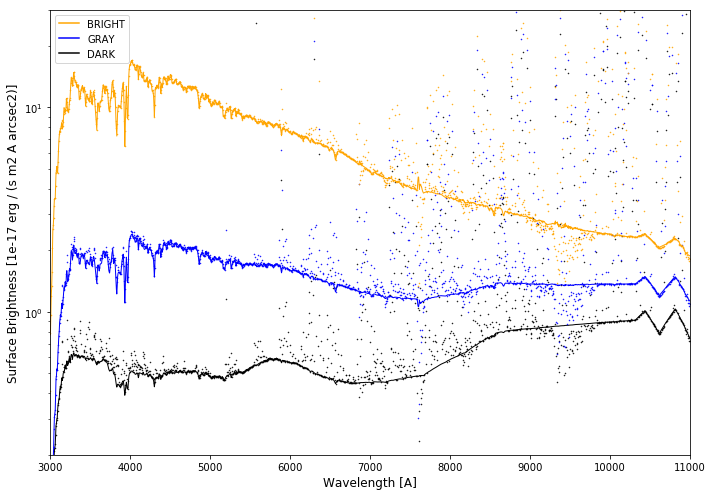

In [1005]:
def plot_sky_models(save=None):
    fig = plt.figure(figsize=(10, 7))
    scale = 1e17
    plt.plot(sb_lam.value, scale * sb_dark.value, '.', ms=1, c='black')
    plt.plot(sb_lam.value, scale * sb_dark_cont.value, '-', lw=1, c='black')
    plt.plot(sb_lam.value, scale * sb_gray.value, '.', ms=1, c='blue')
    plt.plot(sb_lam.value, scale * sb_gray_cont.value, '-', lw=1, c='blue')
    plt.plot(sb_lam.value, scale * sb_bright.value, '.', ms=1, c='orange')
    plt.plot(sb_lam.value, scale * sb_bright_cont.value, '-', lw=1, c='orange')
    plt.yscale('log')
    plt.xlim(sb_lam.value[0], sb_lam.value[-1])
    plt.ylim(0.2, 30)
    plt.xlabel('Wavelength [A]', fontsize='large')
    plt.ylabel('Surface Brightness [1e-17 erg / (s m2 A arcsec2)]', fontsize='large')
    plt.plot([], [], c='orange', label='BRIGHT')
    plt.plot([], [], c='blue', label='GRAY')
    plt.plot([], [], c='black', label='DARK')
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_sky_models(save='sky_models.png')

## Photon Rates

Convert surface brightness to photons per wavelength bin using the conversion:
$$
A_{\text{eff}} \frac{\lambda \Delta\lambda }{h c}
$$

In [160]:
Aeff = 8.67871 * u.m ** 2 # DESI primary adjusted for central obscuration
hc = astropy.constants.h * astropy.constants.c
desi_photons_per_bin_conv = Aeff * np.gradient(sb_lam) * sb_lam / hc

Copy throughputs from the **Throughput** tab of DESI-347-v13.  Only the corrector coating throughput (row 10) has changed since v12.

In [161]:
thru_wlen = np.array([350, 360, 375, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 980, 995]) * 10
# Telescope to fiber input throughput from row 5.
thru_optics = np.array([
    0.433, 0.585, 0.684, 0.737, 0.748, 0.761, 0.764, 0.766, 0.760, 0.765, 0.747, 0.721, 0.721, 0.748, 0.789, 0.789 #v13
    #0.446, 0.563, 0.688, 0.749, 0.770, 0.762, 0.791, 0.777, 0.780, 0.790, 0.772, 0.757, 0.759, 0.773, 0.794, 0.793 #v12
])
# Non FRD fiber throughput from row 86.
thru_fiber = np.array([
    0.404, 0.451, 0.530, 0.613, 0.950, 0.957, 0.964, 0.967, 0.962, 0.962, 0.970, 0.972, 0.968, 0.954, 0.951, 0.945
])
thru_optics_f = scipy.interpolate.interp1d(
    thru_wlen, thru_optics, kind='linear', assume_sorted=True,
    fill_value='extrapolate', bounds_error=False)
thru_fiber_f = scipy.interpolate.interp1d(
    thru_wlen, thru_fiber, kind='linear', assume_sorted=True,
    fill_value='extrapolate', bounds_error=False)

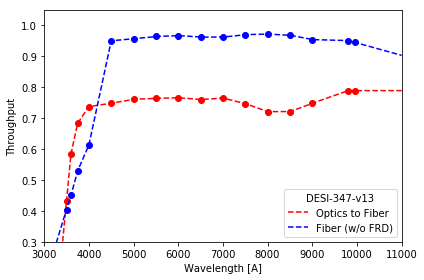

In [805]:
def plot_thru(save=None):
    plt.plot(thru_wlen, thru_optics, 'ro')
    plt.plot(sb_lam, thru_optics_f(sb_lam), 'r--', label='Optics to Fiber')
    plt.plot(thru_wlen, thru_fiber, 'bo')
    plt.plot(sb_lam, thru_fiber_f(sb_lam), 'b--', label='Fiber (w/o FRD)')
    plt.ylabel('Throughput')
    plt.xlabel('Wavelength [A]')
    plt.ylim(0.3, 1.05)
    plt.xlim(3000, 11000)
    plt.legend(title='DESI-347-v13')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_thru(save='desi-throughput.png')

Copy nominal vignetting vs radius from DESI-2632 Fig.2, using the column labeled DESI-0329:

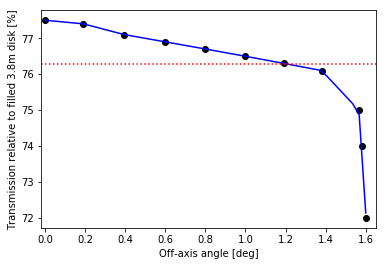

In [1052]:
theta_vignette = np.array([0., 0.19113, 0.39586, 0.59892, 0.79953, 0.99705, 1.19081, 1.38022, 1.56490, 1.58311, 1.60125])
frac_vignette = np.array([0.775, 0.774, 0.771, 0.769, 0.767, 0.765, 0.763, 0.761, 0.750, 0.740, 0.720])
vignette_f = scipy.interpolate.interp1d(theta_vignette, frac_vignette, assume_sorted=True, kind=1)
theta = np.linspace(0, 1.6, 50)
plt.plot(theta_vignette, 100 * frac_vignette, 'ko')
plt.plot(theta, 100 * vignette_f(theta), 'b-')
plt.xlabel('Off-axis angle [deg]')
plt.ylabel('Transmission relative to filled 3.8m disk [%]')
plt.axhline(100 * 0.9835 * 0.7756, c='r', ls=':')
plt.xlim(-0.02, 1.65);

The throughput curves above from DESI-347 include an area-weighted average vignetting of 0.9835 relative to the central value (0.7756), which is . Therefore the worst case additional vignetting factor for the sky fibers, corresponding to 73% transmission, is:

In [1061]:
vignette_factor = 0.73 / (0.9835 * 0.7756)
print(np.round(100 * vignette_factor, 1))

95.7


Calculate the rate of photons exiting a sky fiber in #/s/A, including losses from:
 - vignetting at field edge
 - SMA connector at spool box

In [1049]:
# Physical fiber size.
fiber_diam = 107. * u.um
# Plate scales at r ~ 410mm are 70.5 (sagital) and 77.0 (meridonal) from DESI-329 Fig.8.
fiber_sky_area = 0.25 * np.pi * fiber_diam ** 2 / (70.5 * u.um / u.arcsec) / (77.0 * u.um / u.arcsec)
print(np.round(fiber_sky_area, 3))

1.656 arcsec2


In [1072]:
def get_detected_photon_rate(surface_brightness, sma_transmission=0.8):
    # Calculate mean detected photons per simulation wavelength bin.
    photons_per_bin = vignette_factor * fiber_sky_area * desi_photons_per_bin_conv * surface_brightness
    # Apply throughput.
    photons_per_bin *= sma_transmission * thru_optics_f(sb_lam) * thru_fiber_f(sb_lam)
    return photons_per_bin.si / np.gradient(sb_lam)

In [1073]:
phot_dark = get_detected_photon_rate(sb_dark)
phot_dark_cont = get_detected_photon_rate(sb_dark_cont)
phot_gray = get_detected_photon_rate(sb_gray)
phot_gray_cont = get_detected_photon_rate(sb_gray_cont)
phot_bright = get_detected_photon_rate(sb_bright)
phot_bright_cont = get_detected_photon_rate(sb_bright_cont)

Define the SkyCamera filters:

In [361]:
filter_names=('450FS80', '540FS10', '577FS10', '610FS10', '675FS10', '820FS10')

In [362]:
def get_filters():
    reader = astropy.io.ascii.get_reader(Reader=astropy.io.ascii.Csv)
    reader.header.start_line = 6
    reader.data.start_line = 7
    curves = []
    for name in filter_names:
        path = 'filters/{}.csv'.format(name)
        if not os.path.exists(path):
            data = requests.get('https://www.andovercorp.com/static/csv/{}.csv'.format(name))
            with open(path, 'w') as f:
                f.write(data.text)
            print('Downloaded {}'.format(path))
        else:
            print('Using cached filter curve for {}.'.format(name))
        t = reader.read(path)
        lam, resp = np.array(t.columns[0]), np.array(t.columns[1])
        resp[[0, -1]] = 0.
        # Create speclite filters
        # http://speclite.readthedocs.io/en/latest/filters.html#custom-filters
        curve = speclite.filters.FilterResponse(
            wavelength = lam * u.nm, response = 1e-2 * resp,
            meta = dict(group_name='DESI', band_name='SKY' + name))
        curves.append(curve)
    return speclite.filters.FilterSequence(curves)

filters = get_filters()

Using cached filter curve for 450FS80.
Using cached filter curve for 540FS10.
Using cached filter curve for 577FS10.
Using cached filter curve for 610FS10.
Downloaded filters/675FS10.csv
Using cached filter curve for 820FS10.


In [363]:
filters.effective_wavelengths

<Quantity [ 4743.04016114, 5420.49534193, 5780.94074073, 6119.76588047,
            6757.66298726, 8224.8800539 ] Angstrom>

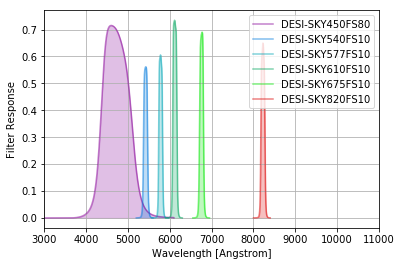

In [800]:
speclite.filters.plot_filters(filters, wavelength_limits=(3000, 11000))
plt.savefig('andover.png')

Build an approximate model of the lens tranmission curve, based on https://doi.org/10.1364/OE.17.020211 and http://www.graphics.cornell.edu/online/measurements/filter-spectra/index.html. Note that the second link shows a notch from 900-1000nm, which we don't include here, but it does not affect our results since we only use filters below 900nm.

In [1065]:
lens_lam = np.array([3000, 4000, 5000, 7000, 11000])
lens_trans = np.array([0., 0.8, 0.9, 0.9, 0.5])
lens_interpolator = scipy.interpolate.interp1d(
    lens_lam, lens_trans, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False)
def lens_transmission(lam):
    return lens_interpolator(lam.to(u.Angstrom).value)

Build an approximate model of the CCD QE curve shown in Fig. 5 of the [KAF-6303e datasheet](http://www.onsemi.com/pub/Collateral/KAF-6303-D.PDF):

In [298]:
qe_lam = np.array([3000, 4000, 5800, 6600, 10400])
qe_val = np.array([   0,  0.3, 0.65, 0.65,     0])
qe_interpolator = scipy.interpolate.interp1d(
    qe_lam, qe_val, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False)
def sensor_QE(lam):
    return qe_interpolator(lam.to(u.Angstrom).value)

Plot both models:

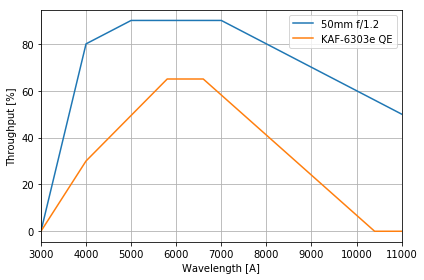

In [1082]:
def plot_skycam_models(save=None):
    lam = np.arange(3000, 11050, 50)
    QE = sensor_QE(lam * u.Angstrom)
    lens = lens_transmission(lam * u.Angstrom)
    plt.plot(lam, 100 * lens, label='50mm f/1.2')
    plt.plot(lam, 100 * QE, label='KAF-6303e QE')
    plt.grid()
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Throughput [%]')
    plt.legend()
    plt.xlim(lam[0], lam[-1])
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_skycam_models(save='thru-models.png')

Plot photon rates exiting sky fibers under different conditions, including DESI throughput, vignetting at the field edge, and SMA connector losses:

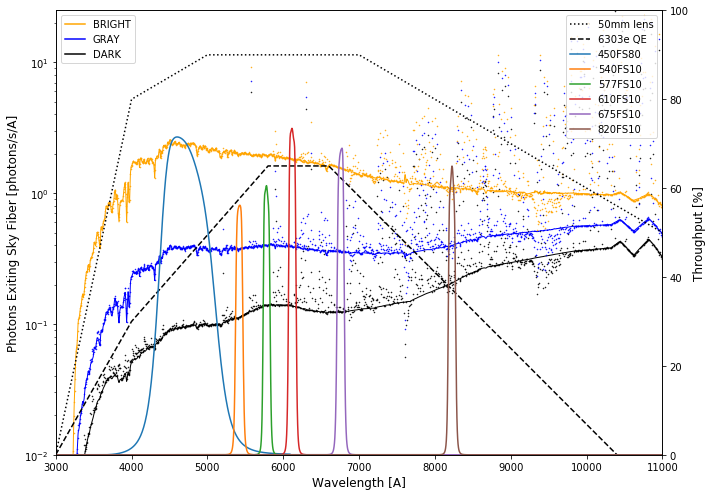

In [1084]:
def plot_photon_rates(show_filters=True, save=None):
    fig = plt.figure(figsize=(10, 7))
    unit = 1 / (u.s * u.Angstrom)
    plt.plot(sb_lam.value, phot_dark.to(unit).value, '.', ms=1, c='black')
    plt.plot(sb_lam.value, phot_dark_cont.to(unit).value, '-', lw=1, c='black')
    plt.plot(sb_lam.value, phot_gray.to(unit).value, '.', ms=1, c='blue')
    plt.plot(sb_lam.value, phot_gray_cont.to(unit).value, '-', lw=1, c='blue')
    plt.plot(sb_lam.value, phot_bright.to(unit).value, '.', ms=1, c='orange')
    plt.plot(sb_lam.value, phot_bright_cont.to(unit).value, '-', lw=1, c='orange')
    plt.yscale('log')
    plt.ylim(1e-2, 25.)
    plt.xlabel('Wavelength [A]', fontsize='large')
    plt.ylabel('Photons Exiting Sky Fiber [photons/s/A]', fontsize='large')
    plt.plot([], [], c='orange', label='BRIGHT')
    plt.plot([], [], c='blue', label='GRAY')
    plt.plot([], [], c='black', label='DARK')
    plt.legend(loc='upper left')
    if show_filters:
        rhs = plt.twinx()
        rhs.plot(sb_lam.value, 100 * lens_transmission(sb_lam), 'k:', label='50mm lens')
        rhs.plot(sb_lam.value, 100 * sensor_QE(sb_lam), 'k--', label='6303e QE')
        for i, name in enumerate(filter_names):
            response = 100 * filters[i](sb_lam)
            plt.plot(sb_lam.value, response, label=name)
        rhs.set_ylim(0, 100)
        rhs.legend(loc='upper right')
        rhs.set_ylabel('Throughput [%]', fontsize='large')
    plt.xlim(sb_lam.value[0], sb_lam.value[-1])
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_photon_rates(save='photon_rates.png')

Calculate filter-convolved rates of detected electrons:

In [1075]:
def get_filter_rates(photons, include_lens=True, include_sensor=True):
    """Return a dictionary of detected electron rates for each filter"""
    rates = {}
    phot = photons.copy()
    for i, name in enumerate(filter_names):
        pad_phot, pad_lam = filters[i].pad_spectrum(phot, sb_lam)
        if include_lens:
            pad_phot = pad_phot * lens_transmission(pad_lam)
        if include_sensor:
            pad_phot = pad_phot * sensor_QE(pad_lam)
        conv = speclite.filters.FilterConvolution(
            filters[i], pad_lam, interpolate=True,
            units=1 / (u.s * u.Angstrom), photon_weighted=False)
        rates[name] = conv(pad_phot).to(u.Hz)
    return rates

In [1083]:
def calculate_rates(photons, photons_cont, trans_ma):
    rates = {}
    # Calculate nominal rates including continuum + emission w/ extinction.
    rates['nominal'] = get_filter_rates(photons)
    # Calculate rates due to (extincted) airglow emission only.
    rates['emission'] = get_filter_rates(photons - photons_cont * trans_ma)
    # Calculate rates due to continuum w/o extinction.
    rates['continuum'] = get_filter_rates(photons_cont)
    # Calculate rates due to continuum w/ extinction.
    rates['extincted'] = get_filter_rates(photons_cont * trans_ma)    
    return rates

In [1077]:
filter_rates = {}
filter_rates['DARK'] = calculate_rates(phot_dark, phot_dark_cont, ma_dark)
filter_rates['GRAY'] = calculate_rates(phot_gray, phot_gray_cont, ma_gray)
filter_rates['BRIGHT'] = calculate_rates(phot_bright, phot_bright_cont, ma_bright)

In [1078]:
def rates_table():
    print('| Filter  |      DARK | Airglow | Absorp. |      GRAY | Airglow | Absorp. |    BRIGHT | Airglow | Absorp. |')
    print('|---------|-----------|---------|---------|-----------|---------|---------|-----------|---------|---------|')
    for name in filter_names:
        print('| {} '.format(name), end='')
        for conditions in 'DARK', 'GRAY', 'BRIGHT':
            nominal = filter_rates[conditions]['nominal'][name]
            emission = filter_rates[conditions]['emission'][name]
            continuum = filter_rates[conditions]['continuum'][name]
            extincted = filter_rates[conditions]['extincted'][name]
            emit_frac = emission / nominal
            ext_frac = (continuum - extincted) / continuum
            print('| {:6.2f} | {:6.1f}% | {:6.1f}% '.format(nominal, 100 * emit_frac, 100 * ext_frac), end='')
        print('|')
        
rates_table()

| Filter  |      DARK | Airglow | Absorp. |      GRAY | Airglow | Absorp. |    BRIGHT | Airglow | Absorp. |
|---------|-----------|---------|---------|-----------|---------|---------|-----------|---------|---------|
| 450FS80 |  20.43 Hz |    3.2% |    0.0% |  78.73 Hz |    1.0% |    0.0% | 473.46 Hz |    0.2% |    0.0% |
| 540FS10 |   3.41 Hz |    0.4% |    0.0% |  11.34 Hz |    0.2% |    0.0% |  60.35 Hz |    0.0% |    0.0% |
| 577FS10 |   4.66 Hz |    0.3% |    0.0% |  13.40 Hz |    0.1% |    0.0% |  65.14 Hz |    0.0% |    0.0% |
| 610FS10 |   6.39 Hz |    4.8% |    0.0% |  17.64 Hz |    2.1% |    0.0% |  80.96 Hz |    0.5% |   -0.0% |
| 675FS10 |   4.97 Hz |    4.7% |    0.0% |  14.00 Hz |    2.0% |    0.0% |  59.92 Hz |    0.5% |    0.0% |
| 820FS10 |   4.52 Hz |   21.0% |    4.3% |   8.00 Hz |   14.3% |    5.2% |  20.06 Hz |    6.1% |    5.1% |


Copy the output above into this cell to get it formatted:

| Filter  |      DARK | Airglow | Absorp. |      GRAY | Airglow | Absorp. |    BRIGHT | Airglow | Absorp. |
|---------|-----------|---------|---------|-----------|---------|---------|-----------|---------|---------|
| 450FS80 |  20.43 Hz |    3.2% |    0.0% |  78.73 Hz |    1.0% |    0.0% | 473.46 Hz |    0.2% |    0.0% |
| 540FS10 |   3.41 Hz |    0.4% |    0.0% |  11.34 Hz |    0.2% |    0.0% |  60.35 Hz |    0.0% |    0.0% |
| 577FS10 |   4.66 Hz |    0.3% |    0.0% |  13.40 Hz |    0.1% |    0.0% |  65.14 Hz |    0.0% |    0.0% |
| 610FS10 |   6.39 Hz |    4.8% |    0.0% |  17.64 Hz |    2.1% |    0.0% |  80.96 Hz |    0.5% |   -0.0% |
| 675FS10 |   4.97 Hz |    4.7% |    0.0% |  14.00 Hz |    2.0% |    0.0% |  59.92 Hz |    0.5% |    0.0% |
| 820FS10 |   4.52 Hz |   21.0% |    4.3% |   8.00 Hz |   14.3% |    5.2% |  20.06 Hz |    6.1% |    5.1% |

In [312]:
def print_zstats():
    elg_oii, elg_zmin, elg_zmax = 3727.5, 0.6, 1.6
    print('ELG: {:.1f} - {:.1f} A'.format(elg_oii * (1 + elg_zmin), elg_oii * (1 + elg_zmax)))
    bgs_break, bgs_zmin, bgs_zmax = 3900., 0., 0.5
    print('BGS: {:.1f} - {:.1f} A'.format(bgs_break * (1 + bgs_zmin), bgs_break * (1 + bgs_zmax)))
    
print_zstats()

ELG: 5964.0 - 9691.5 A
BGS: 3900.0 - 5850.0 A


## Camera Response

In [1091]:
def camera_response(conditions, filter_name, texp=60 * u.s,
                    dark_current=0.5 * u.electron / (u.pix * u.s),
                    thru=1.0, noisefac=1., magnification=1., binning=1, verbose=False):
    """Calculate the camera response. The readnoise is hardcoded from lab measurements.
    
    Paramters
    ---------
    conditions : str
        Conditions defined in filter_rates to use.
    filter_name : str
        Filter name defined in filter_rates to use.
    texp : astropy.units.Quantity
        Exposure time to use.
    dark_current : astropy.units.Quantity
        Dark current in electrons / s per unbinned pixel. A binned pixel
        has a dark current that is a larger by a factor binning ** 2.
    thru : float
        Additional throughput factor to apply to the nominal specs.
    noisefac : float
        Amount to increase the noise relative to nominal specs.
    magnification : float
        Optical magnification of fiber tips to image plane.
    binning : int
        Pixel binning along each axis. Increases dark current and
        signal electrons per readout pixel by binning ** 2.
        Readout noise is assumed not to increase.
        
    Returns
    -------
    tuple
        Tuple (SNR, nelec_fiber, base_noise_var, var_fractions).
    """
    assert binning in (1, 2), 'binning must be 1 or 2.'
    # Hardcode measurements from Ashley using the CI cameras.
    read_noise = (12 if binning == 1 else 16) * u.electron / u.pixel
    # Lookup the detected electron rate to use.
    rate = filter_rates[conditions]['nominal'][filter_name]    
    # Calculate the vignetted acceptance.
    fiber_fratio = 3.8
    lens_fratio = 1.2
    Vf = min(1, ((fiber_fratio / lens_fratio) * magnification / (1 + magnification)) ** 2)
    # Calculate the pixel linear dimension after binning.
    pixsize = binning * 9 * u.um / u.pix
    # Calculate number of detected electrons.
    nelec_fiber = (rate * texp * thru * Vf).to(1).value
    # Calculate the number of pixels illuminated by this fiber.
    # Does not account for diffusion spreading.
    area_pixels = ((np.pi / 4 * (fiber_diam * magnification) ** 2)
                   / pixsize ** 2).to(u.pix ** 2).value
    # Calculate the noise per pixel.
    dark_elec_pixel = (binning ** 2 * dark_current * texp).to(u.electron / u.pix).value
    read_elec_rms = read_noise.to(u.electron / u.pix).value
    base_noise_var = dark_elec_pixel + read_elec_rms ** 2
    var_sky_pixel = nelec_fiber / area_pixels
    var_pixel = var_sky_pixel + base_noise_var
    var_fractions = np.array([var_sky_pixel, dark_elec_pixel, read_elec_rms ** 2]) / var_pixel
    noise_pixel = np.sqrt(var_pixel)
    # Calculate the RMS noise of the illuminated pixel sum, including the noise fudge factor.
    noise_fiber = noisefac * noise_pixel * np.sqrt(area_pixels)
    # Calculate SNR ratio of the illuminated area sum.
    SNR = nelec_fiber / noise_fiber

    if verbose:
        print('signal: {:.1f} electrons / {:.1f} pixels'.format(nelec_fiber, area_pixels))
        print(' noise: {:.1f} electrons / pixel'.format(noise_pixel))
        print('noise fractions (sky, dark, read):', var_fractions)
        print('vignetted acceptance: {:.1f}%'.format(100 * Vf))
        print('   SNR: {:.3f}'.format(SNR))

    return SNR, nelec_fiber, base_noise_var, var_fractions

In [1093]:
camera_response('DARK', '610FS10', 200 * u.s, binning=2, magnification=0.5, verbose=True);

signal: 1278.5 electrons / 6.9 pixels
 noise: 29.0 electrons / pixel
noise fractions (sky, dark, read): [ 0.21929074  0.47604223  0.30466703]
vignetted acceptance: 100.0%
   SNR: 16.744


In [1129]:
def plot_response_vs_texp(conditions, filter_name, tmax, magnification, snr_min=10., ax=None):
    num_texp = 50
    texp = np.linspace(0, 1, num_texp) * tmax
    ax = ax or plt.gca()
    rhs = ax.twinx()
    for j, binning in enumerate((2, 1)):
        ls = ('-', '--')[j]
        snr = np.empty((num_texp))
        frac = np.empty((num_texp, 3))
        for i, t in enumerate(texp):
            snr[i], _, _, frac[i] = camera_response(
                conditions, filter_name, t, binning=binning, magnification=magnification)
        ax.plot(texp.value, snr, 'k', ls=ls, label='{0}x{0}'.format(binning))
        rhs.plot(texp.value, 100 * frac[:, 2], 'b', ls=ls)
    ax.axhspan(0., snr_min, facecolor='r', alpha=0.2)
    ax.legend(ncol=2, loc='lower center')
    ax.set_xlabel('Exposure Time [s]')
    ax.set_ylabel('Signal-to-noise ratio')
    rhs.set_ylabel('Read-noise variance / total [%]', color='b')
    rhs.set_ylim(0, 100)
    ax.set_ylim(0, None)
    ax.set_xlim(texp[0].value, texp[-1].value)
    plt.text(0.5, 0.2, '{}-{}'.format(conditions, filter_name),
             transform=ax.transAxes, horizontalalignment='center', fontsize='large')
    plt.text(0.5, 0.13, 'Magnification = {}'.format(magnification),
             transform=ax.transAxes, horizontalalignment='center', fontsize='large')

In [1130]:
def plot_response_vs_mag(conditions, filter_name, texp, snr_min=10., ax=None):
    num_M = 50
    Mvec = np.linspace(0.1, 1., num_M)
    ax = ax or plt.gca()
    rhs = ax.twinx()
    for j, binning in enumerate((2, 1)):
        ls = ('-', '--')[j]
        snr = np.empty((num_M))
        frac = np.empty((num_M, 3))
        for i, M in enumerate(Mvec):
            snr[i], _, _, frac[i] = camera_response(
                conditions, filter_name, texp, binning=binning, magnification=M)
        ax.plot(Mvec, snr, 'k', ls=ls, label='{0}x{0}'.format(binning))
        rhs.plot(Mvec, 100 * frac[:, 2], 'b', ls=ls)
    ax.axhspan(0., snr_min, facecolor='r', alpha=0.2)
    ax.set_xlabel('Magnification')
    ax.set_ylabel('Signal-to-noise ratio')
    rhs.set_ylabel('Read-noise variance / total [%]', color='b')
    rhs.set_ylim(0, 100)
    ax.legend(ncol=2, loc='lower center')
    ax.set_ylim(0, None)
    ax.set_xlim(Mvec[0], Mvec[-1])
    plt.text(0.5, 0.2, '{}-{}'.format(conditions, filter_name),
             transform=ax.transAxes, horizontalalignment='center', fontsize='large')
    plt.text(0.5, 0.13, 'Exposure time = {}'.format(texp),
             transform=ax.transAxes, horizontalalignment='center', fontsize='large')

Forecast SNR for the most challenging cases: DARK sky and either dark-length exposures with 610FS10 or bright-length exposures with 450FS80:

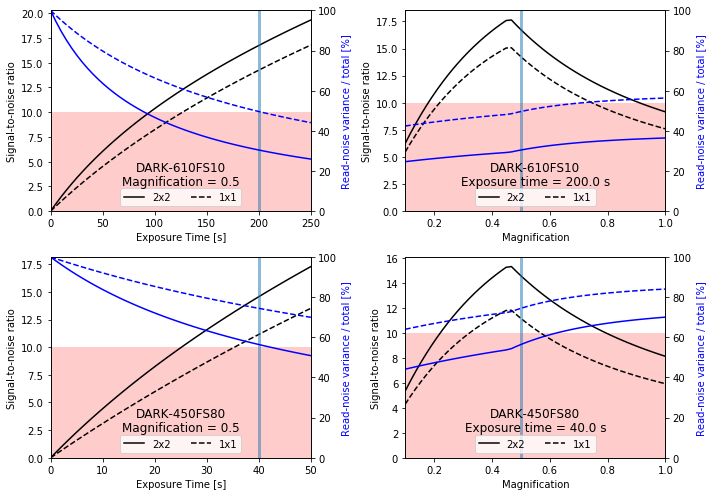

In [1131]:
def plot_response(magnification=0.5, save=None):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7))

    texp=200 * u.s
    plot_response_vs_texp('DARK', '610FS10', 250 * u.s, magnification, ax=ax[0, 0])
    ax[0, 0].axvline(texp.value, lw=3, alpha=0.5)
    plot_response_vs_mag('DARK', '610FS10', texp, ax=ax[0, 1])
    ax[0, 1].axvline(magnification, lw=3, alpha=0.5)

    texp=40 * u.s
    plot_response_vs_texp('DARK', '450FS80', 50 * u.s, magnification, ax=ax[1, 0])
    ax[1, 0].axvline(texp.value, lw=3, alpha=0.5)
    plot_response_vs_mag('DARK', '450FS80', texp, ax=ax[1, 1])
    ax[1, 1].axvline(magnification, lw=3, alpha=0.5)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_response(save='response.png')

In [1139]:
def get_fiber_image(conditions, filter_name, texp, seed=0, charge_diffusion=0. * u.pix,
                    magnification=0.5, binning=2, stamp_rel_size=2, ax=None, vmin=None, vmax=None):
    """Simulate a postage stamp containing a fiber image"""
    gen = np.random.RandomState(seed)
    # Calculate the camera response.
    SNR, nelec_fiber, base_noise_var, _ = camera_response(
        conditions, filter_name, texp, magnification=magnification, binning=binning)
    # Calculate the pixel linear dimension after binning.
    pixsize = binning * 9 * u.um / u.pix
    fiber_diam_pixels = (fiber_diam * magnification / pixsize).to(u.pix).value
    # Generate a postage stamp sized to the fiber image.
    size = int(np.ceil(stamp_rel_size * fiber_diam_pixels))
    rmax = 0.5 * fiber_diam_pixels
    img = np.zeros((size, size))
    # Shoot each photon individually.
    n = gen.poisson(nelec_fiber)
    r = 0.5 * fiber_diam_pixels * np.sqrt(gen.uniform(size=n))
    phi = 2 * np.pi * gen.uniform(size=n)
    x = 0.5 * size + r * np.cos(phi)
    y = 0.5 * size + r * np.sin(phi)
    # Apply a random subpixel centroid offset.
    x += gen.uniform(-0.5, +0.5)
    y += gen.uniform(-0.5, +0.5)
    # Apply charge diffusion.
    if charge_diffusion > 0:
        x += gen.normal(scale=charge_diffusion.to(u.pix).value, size=n)
        y += gen.normal(scale=charge_diffusion.to(u.pix).value, size=n)
    # Bin each photon into pixels.
    img, _, _ = np.histogram2d(x, y, bins=(size, size), range=((0, size), (0, size)))
    # Add realization of dark current + readout noise.
    img += gen.normal(size=(size, size), scale=np.sqrt(base_noise_var))
    # Plot the image if requested.
    if ax is not None:
        if vmin is None:
            vmin = -2 * np.sqrt(base_noise_var)
        if vmax is None:
            vmax = np.percentile(img, 95)
        p = ax.imshow(img, interpolation='none', aspect=1., cmap='viridis', vmin=vmin, vmax=vmax)
        ax.axis('off')
        ax.text(0.05, 0.9, '{}-{}'.format(conditions, filter_name), color='w', fontweight='bold',
                fontsize='large', transform=ax.transAxes)
        ax.text(0.05, 0.05, 'SNR={:.1f}'.format(SNR), color='w', fontweight='bold',
                fontsize='large', transform=ax.transAxes)
        #plt.colorbar(p, ax=ax, label='Electrons / {:.0f}'.format(texp))
    
    return img

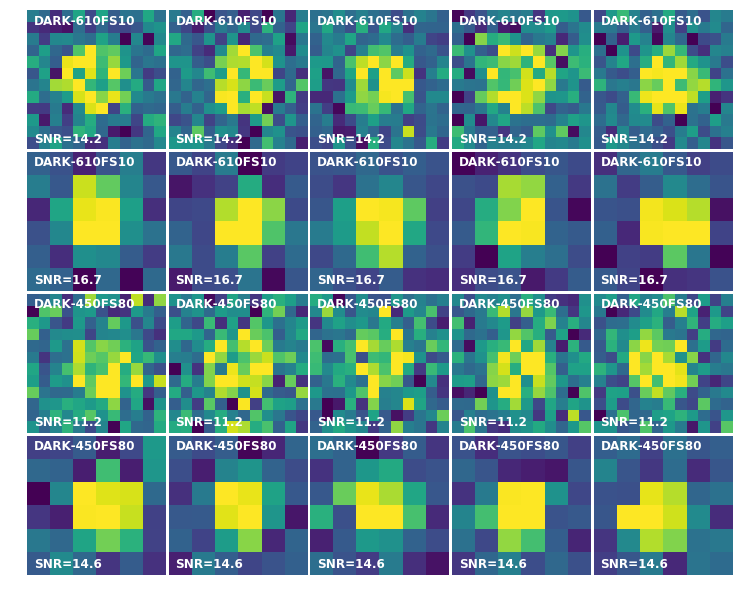

In [1140]:
def draw_images(magnification=0.5, nseed=5, save=None):
    fig, axes = plt.subplots(4, nseed, figsize=(10, 8))
    for i, row in enumerate(axes):
        if i < 2:
            args = 'DARK', '610FS10', 200 * u.s
        else:
            args = 'DARK', '450FS80', 40 * u.s
        binning = 2 if i % 2 else 1
        for j, ax in enumerate(row):
            get_fiber_image(*args, binning=binning, ax=ax, seed=j, magnification=magnification)
    plt.subplots_adjust(hspace=0.02, wspace=0.02, left=0.01, right=0.99, bottom=0.01, top=0.99)
    if save:
        plt.savefig(save)
    
draw_images(save='simulated-images.png')

## Filter Refraction

The filter has a thickness $t$ and index $n$, so a ray incident at $y$ with angle $\theta$ exits at $y'$ also at angle $\theta$, with
$$
y' = y + t \tan\theta'
$$
with
$$
\frac{\sin\theta'}{\sin\theta} = \frac{1}{n} \; .
$$
A ray that would intercept $y=0$ at a distance $z$ from the filter front face (in the absence of the filter) now intercepts at $z + \Delta z$ with
$$
\Delta z(\theta) = t \left( 1 - \frac{\tan\theta'}{\tan\theta}\right)
$$

fratio = 1.900


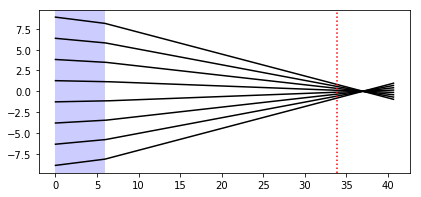

In [910]:
def filter_refract(n=2.05, t=5.9, magnification=0.5, fiber_fratio=3.8, zfilter=27.98, nray=8, save=None):
    zfocus = zfilter + t
    fratio = magnification * fiber_fratio
    print(f'fratio = {fratio:.3f}')
    ymax = 0.5 * zfocus / fratio
    z = np.linspace(0, 1.2 * zfocus, 500)
    y = np.empty_like(z)
    infilt = z < t
    fig = plt.figure(figsize=(8, 3))
    for y0 in np.linspace(-ymax, ymax, nray):
        theta = np.arctan(y0 / zfocus)
        thetap = np.arcsin(np.sin(theta) / n)
        slope = np.tan(thetap)
        y[infilt] = y0 - slope * z[infilt]
        yp = y0 - slope * t
        slope = np.tan(theta)
        y[~infilt] = yp - slope * (z[~infilt] - t)
        plt.plot(z, y, 'k-')
    plt.axvline(zfocus, color='r', ls=':')
    plt.axvspan(0, t, facecolor='blue', alpha=0.2)
    plt.gca().set_aspect(1)
    #plt.tight_layout()
    if save:
        plt.savefig(save)
        
filter_refract(save='filter-refract.png')

Since $\Delta z$ depends on $\theta$, a converge beam no longer achieves a perfect focus. Instead, an ray with angle $\theta$ hits an image plane at $z'$ with a lateral offset of:
$$
\Delta y(\theta, z') = \left(z + \Delta z(\theta) - z'\right) \tan\theta
$$
If we assume a uniformly illuminated cone with focal ratio $f$, then
$$
|\theta| \le \theta_\max = \arctan(1/(2f))
$$
and each angle $\theta$ has an associated weight
$$
\omega(\theta) = |\tan(\theta)| \; .
$$
Therefore, the spot at $z'$ has an RMS spread of
$$
\sigma(z') = \frac{\int_{-\theta_\max}^{+\theta_\max} \omega(\theta) \Delta y(\theta, z')^2 d\theta}
{\int_{-\theta_\max}^{+\theta_\max} \omega(\theta) d\theta}
$$

Minimum blur of 3.2um at dz=3.071mm


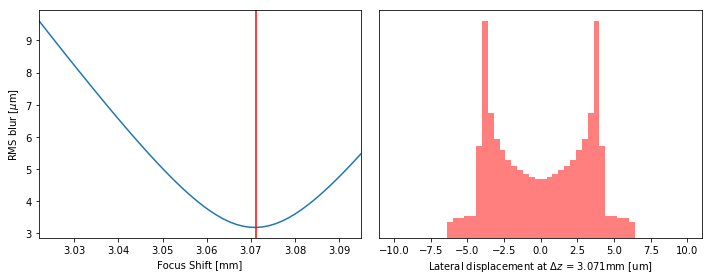

In [905]:
def plot_filter_defocus(n=2.05, t=5.9, magnification=0.5, fiber_fratio=3.8, nz=50, save=None):
    
    theta_max = np.arctan(1 / (2 * magnification * fiber_fratio))
    theta = np.linspace(-theta_max, theta_max, 2000)
    thetap = np.arcsin(np.sin(theta) / n)
    dz = t * (1 - np.tan(thetap) / np.tan(theta))
    wgt = np.abs(np.tan(theta))
    wgt_sum = wgt.sum()
    
    dz_vec = np.linspace(np.min(dz), np.max(dz), nz).reshape(-1, 1)
    dy_vec = 1e3 * np.tan(theta) * (dz - dz_vec)
    rms = np.sqrt(np.sum(dy_vec ** 2 * wgt, axis=1) / (wgt_sum - 1))
    dz_best = dz_vec[np.argmin(rms)][0]
    print('Minimum blur of {:.1f}um at dz={:.3f}mm'.format(np.min(rms), dz_best))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(dz_vec, rms)
    ax[0].axvline(dz_best, c='r', ls='-')
    ax[0].set_xlabel('Focus Shift [mm]')
    ax[0].set_ylabel('RMS blur [$\mu$m]')
    ax[0].set_xlim(dz_vec[0], dz_vec[-1])
    '''
    for i in range(nz):
        # Calculate the weighted mean and variance of dy at this z.
        mean = np.sum(dy_vec[i] * wgt) / wgt_sum
        rms = np.sqrt(np.sum(dy_vec[i] ** 2 * wgt) / (wgt_sum - 1))
        print('mean', mean, 'rms', rms)
        ax[0].axhline(z_vec[i], ls=':', c='r')
        ax[1].hist(dy_vec[i], weights=wgt, bins=100, range=(-20, 20),
                   normed=True, histtype='step')
    '''
    dy = 1e3 * np.tan(theta) * (dz - dz_best)
    ax[1].hist(dy, weights=wgt, bins=50, range=(-10, 10),
               color='r', histtype='stepfilled', alpha=0.5)
    ax[1].set_xlabel('Lateral displacement at $\Delta z$ = {:.3f}mm [um]'.format(dz_best))
    ax[1].set_yticks([])
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_filter_defocus(save='filter_defocus.png')

Minimum blur of 0.4um at dz=3.035mm


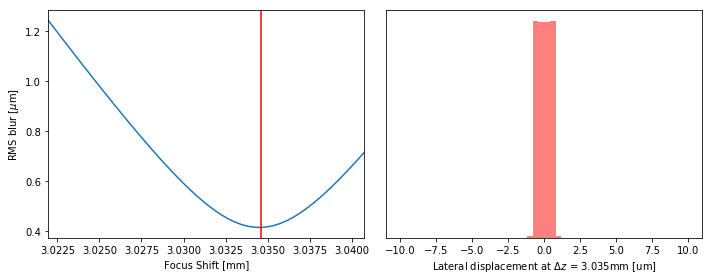

In [906]:
plot_filter_defocus(magnification=1.0)

## Lens Selection

In [911]:
def draw_optics(magnification=0.5, fiber_fratio = 3.8, offsets=(0., 0.4),
                circle_of_confusion=5 * u.um,
                fig_width=6., zmax=240., ymax=29., save=None):

    focal_length = 50 # mm
    lens_fratio = 1.2
    lens_magnification = 1 / 7.9 # max reproduction ratio

    D_fiber = (magnification + 1.) / magnification * focal_length
    D_ccd = (magnification + 1.) * focal_length
    print('D(fiber) = {:.1f}mm, D(ccd) = {:.1f}mm'.format(D_fiber, D_ccd))
    
    # Calculate the illuminated radius at the lens.
    r_illum = 0.5 * D_fiber / fiber_fratio
    
    # Calculate the f-ratio of the beam focused on the CCD.
    ccd_fratio = magnification * fiber_fratio
    
    # Calculate the extension tube length required.
    D_ext = (magnification - lens_magnification) * focal_length
    
    # Calculate the radius of the lens entrance pupil.
    r_clear_aperture = 0.5 * focal_length / lens_fratio

    # Calculate the vignetting fraction.
    if r_illum > r_clear_aperture:
        vign_acc = (r_clear_aperture / r_illum) ** 2
    else:
        vign_acc = 1.
    print('Vignetted acceptance: {:.1f}%'.format(100 * vign_acc))
    
    # Calculate the depth of field.
    # https://en.wikipedia.org/wiki/Depth_of_field#Derivation_of_the_DOF_formulae
    c = circle_of_confusion.to(u.mm).value
    pm = np.array([-1, +1])
    D_focus = D_fiber * focal_length ** 2 / (
        focal_length ** 2 + pm * lens_fratio * c * (D_fiber - focal_length))
    DOF = 1e3 * (D_focus[0] - D_focus[1])
    print('DOF: {:.1f} um (c={:.1f})'.format(DOF, circle_of_confusion))
    
    z = np.linspace(0., D_fiber + D_ccd, 100)
    y1 = np.empty_like(z)
    y2 = np.empty_like(z)
    
    fig = plt.figure(figsize=(fig_width, 1.1 * fig_width * 2 * ymax / zmax))
    
    ccd_width = 27.65
    for y_offset_fraction in offsets:
        y_offset = y_offset_fraction * ccd_width / magnification
        theta0 = np.arctan(y_offset / D_fiber)
        dtheta = np.arctan(0.5 / fiber_fratio)
        y1[z < D_fiber] = y_offset - np.tan(theta0 - dtheta) * z[z < D_fiber]
        y2[z < D_fiber] = y_offset - np.tan(theta0 + dtheta) * z[z < D_fiber]
        y_offset *= -magnification
        theta0 = np.arctan(y_offset / D_ccd)
        dtheta = np.arctan(0.5 / ccd_fratio)
        y1[z >= D_fiber] = y_offset - np.tan(theta0 - dtheta) * (z[-1] - z[z >= D_fiber])
        y2[z >= D_fiber] = y_offset - np.tan(theta0 + dtheta) * (z[-1] - z[z >= D_fiber])
        
        # Draw the beam exiting the fiber and focusing on the CCD through the lens.
        #y[z < D_fiber] = y_offset + 0.5 * z[z < D_fiber] / fiber_fratio
        #y[z >= D_fiber] = y_offset + 0.5 * (z[-1] - z[z >= D_fiber]) / ccd_fratio

        plt.fill_between(z, y1, y2, color='red', alpha=0.2)
        #plt.plot(z, y1, 'r--', lw=1)
        #plt.plot(z, y2, 'b--', lw=1)
    
    # Draw the lens plane.
    #plt.axvline(D_fiber, c='k', ls='--')
    
    # Draw the CCD plane.
    #plt.axvline(D_fiber + D_ccd, c='b', ls='-', lw=2)
    plt.plot([D_fiber + D_ccd] * 2, [-0.5 * ccd_width, +0.5 * ccd_width], 'b-', lw=2)

    print('Total length = {:.1f}mm'.format(D_fiber + D_ccd))
    print('Extension = {:.1f}mm'.format(D_ext))
    
    # Draw the extension tube extent.
    #plt.axvline(D_fiber + D_ccd - D_ext, c='k', ls=':')
    
    # Draw the lens clear aperture.
    #plt.axhline(+r_clear_aperture, c='k', ls=':')
    #plt.axhline(-r_clear_aperture, c='k', ls=':')

    label = 'M={:.2f}x'.format(magnification)
    xy = 0.02, 0.1
    plt.annotate(label, xy, xy, 'axes fraction', 'axes fraction')
    
    # Calculate the nominal lens-CCD distance (the physical lens length is 47.5mm)
    lens_length = (1 + lens_magnification) * focal_length
    # Draw the lens inner surface.
    plt.plot([D_fiber, D_fiber + lens_length], [+r_clear_aperture] * 2, 'k-', lw=2)
    plt.plot([D_fiber, D_fiber + lens_length], [-r_clear_aperture] * 2, 'k-', lw=2)
    
    plt.xlim(0, zmax)
    plt.ylim(-ymax, +ymax)
    plt.gca().set_aspect(1.)
    plt.subplots_adjust(left=0.05, top=0.99, right=0.99, bottom=0.2)
    if save:
        plt.savefig(save)

D(fiber) = 150.0mm, D(ccd) = 75.0mm
Vignetted acceptance: 100.0%
DOF: 72.0 um (c=5.0 um)
Total length = 225.0mm
Extension = 18.7mm


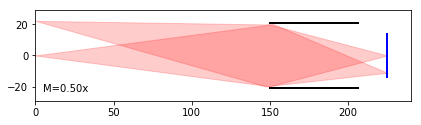

In [912]:
draw_optics(magnification=0.5, save='optics-M0.5.png')

Vignetted acceptance: 100.0%
DOF: 24.0 um (c=5.0 um)
Total length = 200.0mm
Extension = 43.7mm


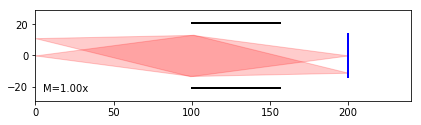

In [814]:
draw_optics(magnification=1.0, save='optics-M1.0.png')

Vignetted acceptance: 13.3%
DOF: 802.4 um (c=5.0 um)
Total length = 491.1mm
Extension = 0.2mm


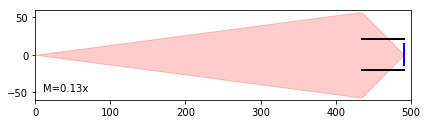

In [815]:
draw_optics(magnification=0.13, zmax=500, ymax=60, offsets=(0,), save='optics-no-extension.png')

## Fiberblock Design

fiber spacing = 10.000mm
Wrote fiberblock.csv


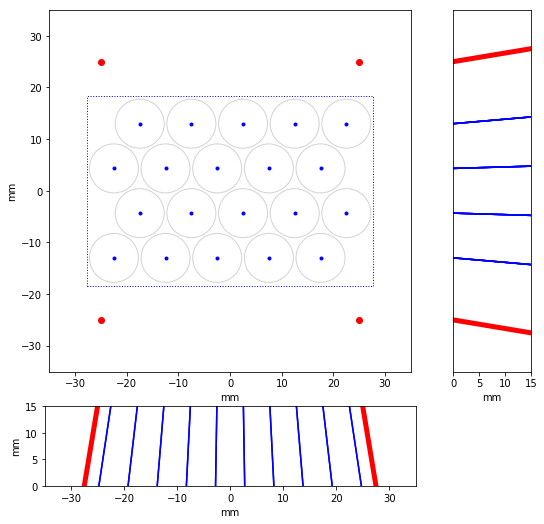

In [1173]:
def draw_block(ccd_height=18.43, ccd_width=27.65, grid=(4, 5), ccd_spacing=5, magnification=0.5,
               xysize=35, dz=15, led=25, save=None):
    # Calculate distance from fiber tip to lens.
    D = (1 + magnification) / magnification * 50
        
    # Demagnify spacing to the fibertip plane.
    fiber_spacing = ccd_spacing / magnification
    print('fiber spacing = {:.3f}mm'.format(fiber_spacing))

    x = np.arange(grid[1]) * fiber_spacing
    y = np.arange(grid[0]) * fiber_spacing * np.sqrt(3) / 2
    xx, yy = np.meshgrid(x, y)
    # Offset odd-numbered rows.
    xx[1::2] += 0.5 * fiber_spacing
    # Center fibers on the origin.
    yy -= yy.mean()
    xx -= xx.mean()

    # Calculate the slope to aim each fiber at the lens center.
    slope = 1 + dz / D
    
    fig = plt.figure(figsize=(9, 9))
    gs = matplotlib.gridspec.GridSpec(4, 4)

    ax = plt.subplot(gs[:-1, :-1])
    ax.plot(xx, yy, 'b.')
    plt.scatter(xx, yy, s=2400, facecolors='none', edgecolors='lightgray')
    
    h, w = ccd_height / magnification, ccd_width / magnification
    ax.add_patch(matplotlib.patches.Rectangle(
        (-0.5 * w, -0.5 * h), w, h, edgecolor='b', facecolor='none', ls=':'))
    
    leds = [-led, -led, +led, +led], [-led, +led, -led, +led]
    plt.plot(*leds, 'ro')
    
    ax.set_xlim(-xysize, +xysize)
    ax.set_ylim(-xysize, +xysize)
    ax.set_xlabel('mm')
    ax.set_ylabel('mm')
    ax.set_aspect(1)
    
    ax = plt.subplot(gs[:-1, -1])
    for y in yy.flatten():
        y2 = y * slope
        ax.plot([0, dz], [y, y2], 'b-')
    ax.plot([0, dz], [+led, +led * slope], 'r-', lw=5)
    ax.plot([0, dz], [-led, -led * slope], 'r-', lw=5)
    ax.set_xlim(0, dz)
    ax.set_ylim(-xysize, +xysize)
    ax.set_xlabel('mm')
    ax.set_xticks([0, 5, 10, 15])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.margins(0.1, 0.1, tight=False)
    
    ax = plt.subplot(gs[-1, :-1])
    for x in xx.flatten():
        x2 = x * slope
        ax.plot([x2, x], [0, dz], 'b-')
    ax.plot([+led * slope, +led], [0, dz], 'r-', lw=5)
    ax.plot([-led * slope, -led], [0, dz], 'r-', lw=5)
    ax.set_xlim(-xysize, +xysize)
    ax.set_ylim(0, dz)
    ax.set_xlabel('mm')
    ax.set_ylabel('mm')
    #ax.set_xticks([])
    ax.set_yticks([0, 5, 10, 15])
    ax.set_aspect(1)
    
    # print coordinates in fibertip plane.
    name = 'fiberblock.csv'
    with open(name, 'w') as f:
        print(' I, J,      X,      Y,   TH_X,   TH_Y', file=f)
        for i in range(grid[0]):
            for j in range(grid[1]):
                x, y = xx[i,j], yy[i,j]
                thx = np.degrees(np.arctan(x / D))
                thy = np.degrees(np.arctan(y / D))
                print(f'{i:2d},{j:2d},{x:+7.3f},{y:+7.3f},{thx:+7.3f},{thy:+7.3f}', file=f)
    print(f'Wrote {name}')
    
    if save:
        plt.savefig(save)
    
draw_block(save='fiberblock.png', ccd_spacing=5)

In [1175]:
astropy.table.Table.read('fiberblock.csv')

I,J,X,Y,TH_X,TH_Y
int64,int64,float64,float64,float64,float64
0,0,-22.5,-12.99,-8.531,-4.95
0,1,-12.5,-12.99,-4.764,-4.95
0,2,-2.5,-12.99,-0.955,-4.95
0,3,7.5,-12.99,2.862,-4.95
0,4,17.5,-12.99,6.654,-4.95
1,0,-17.5,-4.33,-6.654,-1.654
1,1,-7.5,-4.33,-2.862,-1.654
1,2,2.5,-4.33,0.955,-1.654
1,3,12.5,-4.33,4.764,-1.654
